# Исследование пользователей сервиса аренды самокатов GoFast

Для исследования передали данные сервиса GoFast о некоторых пользователях из нескольких городов, а также об их поездках. 

Нужно проанализировать данные и проверить некоторые гипотезы, которые могут помочь бизнесу вырасти. 

Сервисом можно пользоваться:

- **без подписки**
    - абонентская плата отсутствует;
    - стоимость одной минуты поездки — 8 рублей;
    - стоимость старта (начала поездки) — 50 рублей;
- **с подпиской Ultra**
    - абонентская плата — 199 рублей в месяц;
    - стоимость одной минуты поездки — 6 рублей;
    - стоимость старта — бесплатно.
    
Продакт-менеджеры сервиса хотят увеличить количество пользователей с подпиской. Для этого они будут проводить различные акции. 

Сначала хотят выяснить несколько важных моментов:

- Важно понять, тратят ли пользователи с подпиской больше времени на поездки? Если да, то пользователи с подпиской могут быть «выгоднее» для компании?
-  Расстояние одной поездки в 3130 метров — оптимальное с точки зрения износа самоката. Можно ли сказать, что среднее расстояние, которое проезжают пользователи с подпиской за одну поездку, не превышает 3130 метров?
- Будет ли помесячная выручка от пользователей с подпиской по месяцам выше, чем выручка от пользователей без подписки?

**Описание данных**

В основных данных есть информация о пользователях, их поездках и подписках.

**Пользователи — users_go.csv**

    - user_id	уникальный идентификатор пользователя
    - name	имя пользователя
    - age	возраст
    - city	город
    - subscription_type	тип подписки (free, ultra)
    
**Поездки — rides_go.csv**

    - user_id	уникальный идентификатор пользователя
    - distance	расстояние, которое пользователь проехал в текущей сессии (в метрах)
    - duration	продолжительность сессии (в минутах) — время с того момента, как пользователь нажал кнопку 
    «Начать поездку» до момента, как он нажал кнопку «Завершить поездку»
    - date	дата совершения поездки
    
**Подписки — subscriptions_go.csv**

    - subscription_type	тип подписки
    - minute_price	стоимость одной минуты поездки по данной подписке
    - start_ride_price	стоимость начала поездки
    - subscription_fee	стоимость ежемесячного платежа
    
Для исследования необходимо будет:
- выгрузить датасеты и изучить по ними общую информацию;
- проверить на наличие пропущенных значений и дубликатов;
- провести исследовательский анализ данных;
- объединить датасеты в один;
- разделить пользоватей с подпиской сервиса и без;
- посчитать выручку по каждому пользователю помесячно;
- проверить гипотезы, поставленные продакт-менеджерами;
- сделать выводы и рекомендации.

In [1]:
# импортируем библиотеки Pyhton для проведения исследования
import pandas as pd 
import seaborn as sns 
from matplotlib import pyplot as plt
from scipy import stats as st
import numpy as np
from math import factorial
from scipy.stats import binom, norm

## Шаг. Загрузка данных

### Считывание CSV-файлов с данными с помощью библиотеки pandas

In [2]:
# считали файл из csv-файла users_go.csv в переменную data_users
# считали файл из csv-файла rides_go.csv в переменную data_rides
# считали файл из csv-файла subscriptions_go.csv в переменную data_subscriptions
try:
    data_users = pd.read_csv('users_go.csv')
    data_rides = pd.read_csv('rides_go.csv', parse_dates=['date'])
    data_subscriptions = pd.read_csv('subscriptions_go.csv')
except:
    data_users = pd.read_csv('/datasets/users_go.csv')
    data_rides = pd.read_csv('/datasets/rides_go.csv', parse_dates=['date'])
    data_subscriptions = pd.read_csv('/datasets/subscriptions_go.csv')

### Вывод и изучение общей информации о каждом датафрейме

In [3]:
# создали функцию для просмотра и вывода информации датафрейма
def info(data):
    return data.head(10), data.info(), data.isna().sum();

In [4]:
info(data_users) # вывели информацию датафрейма по пользователям

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1565 entries, 0 to 1564
Data columns (total 5 columns):
 #   Column             Non-Null Count  Dtype 
---  ------             --------------  ----- 
 0   user_id            1565 non-null   int64 
 1   name               1565 non-null   object
 2   age                1565 non-null   int64 
 3   city               1565 non-null   object
 4   subscription_type  1565 non-null   object
dtypes: int64(2), object(3)
memory usage: 61.3+ KB


(   user_id        name  age            city subscription_type
 0        1        Кира   22          Тюмень             ultra
 1        2   Станислав   31            Омск             ultra
 2        3     Алексей   20          Москва             ultra
 3        4  Константин   26  Ростов-на-Дону             ultra
 4        5       Адель   28            Омск             ultra
 5        6      Регина   25       Краснодар             ultra
 6        7       Игорь   23            Омск             ultra
 7        8        Юрий   23       Краснодар             ultra
 8        9          Ян   21       Пятигорск             ultra
 9       10     Валерий   18    Екатеринбург             ultra,
 None,
 user_id              0
 name                 0
 age                  0
 city                 0
 subscription_type    0
 dtype: int64)

В датафрейме 4 столбца и 1565  строк. В столбцах user_id и age челочисленный тип данных, в остальных строковый. 

In [5]:
info(data_rides) #вывели инофрмацию датафрейма о поездках

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 18068 entries, 0 to 18067
Data columns (total 4 columns):
 #   Column    Non-Null Count  Dtype         
---  ------    --------------  -----         
 0   user_id   18068 non-null  int64         
 1   distance  18068 non-null  float64       
 2   duration  18068 non-null  float64       
 3   date      18068 non-null  datetime64[ns]
dtypes: datetime64[ns](1), float64(2), int64(1)
memory usage: 564.8 KB


(   user_id     distance   duration       date
 0        1  4409.919140  25.599769 2021-01-01
 1        1  2617.592153  15.816871 2021-01-18
 2        1   754.159807   6.232113 2021-04-20
 3        1  2694.783254  18.511000 2021-08-11
 4        1  4028.687306  26.265803 2021-08-28
 5        1  2770.890808  16.650138 2021-10-09
 6        1  3039.020292  14.927879 2021-10-19
 7        1  2842.118050  23.117468 2021-11-06
 8        1  3412.690668  15.238072 2021-11-14
 9        1   748.690645  15.041884 2021-11-22,
 None,
 user_id     0
 distance    0
 duration    0
 date        0
 dtype: int64)

В датафрейме 4 столбца и 18068  строк. В столбцах user_id челочисленный тип данных, в distance и duration вещественный тип данных, в date - datetime64. 

In [6]:
info(data_subscriptions) #вывели инофрмацию датафрейма о подписках

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 2 entries, 0 to 1
Data columns (total 4 columns):
 #   Column             Non-Null Count  Dtype 
---  ------             --------------  ----- 
 0   subscription_type  2 non-null      object
 1   minute_price       2 non-null      int64 
 2   start_ride_price   2 non-null      int64 
 3   subscription_fee   2 non-null      int64 
dtypes: int64(3), object(1)
memory usage: 196.0+ bytes


(  subscription_type  minute_price  start_ride_price  subscription_fee
 0              free             8                50                 0
 1             ultra             6                 0               199,
 None,
 subscription_type    0
 minute_price         0
 start_ride_price     0
 subscription_fee     0
 dtype: int64)

В датафрейме 4 столбца и 2  строки. В столбцах minute_price, start_ride_price, subscription_fee челочисленный тип данных, в subscription_type строковый. 

## Шаг. Предобработка данных

### Приведение столбца date к типу даты pandas.

In [7]:
# при загрузке данных добавили параметр parse_dates: parse_dates=['date'], тип данных автоматически перевелся в даты
data_rides.dtypes # проверили тип данных в столбцах data_rides

user_id              int64
distance           float64
duration           float64
date        datetime64[ns]
dtype: object

### Создание нового столбца с номером месяца на основе столбца date

In [8]:
# создали новый столбец с номером месяца
data_rides['month_number'] = pd.DatetimeIndex(data_rides['date']).month
data_rides.head() # вывели информацию с новым столбцом - номер месяца

,user_id,distance,duration,date,month_number
0,1,4409.919140,25.599769,2021-01-01,1
1,1,2617.592153,15.816871,2021-01-18,1
2,1,754.159807,6.232113,2021-04-20,4
3,1,2694.783254,18.511000,2021-08-11,8
4,1,4028.687306,26.265803,2021-08-28,8


In [9]:
# проверили за какой период собраны данные
print('Начало периода:', data_rides['date'].min())
print('Конец периода:', data_rides['date'].max())

Начало периода: 2021-01-01 00:00:00
Конец периода: 2021-12-30 00:00:00


Данные в исследовании предоставлены за год.

### Проверка на наличие пропущенных значений и дубликатов в датафреймах.

In [10]:
#создали функцию для проверки пропущенных значений и дубликатов в датафреймах
def values(data):
    return data.isna().sum(), data.duplicated().sum();

In [11]:
values(data_users) # проверили пропущенные значения и дубликаты в датафрейме по пользователям

(user_id              0
 name                 0
 age                  0
 city                 0
 subscription_type    0
 dtype: int64,
 31)

В датафрейме по пользователям пропущенных значений нет. Имеется 31 дубликат.

In [12]:
values(data_rides) # проверили пропущенные значения и дубликаты в датафрейме о поездках

(user_id         0
 distance        0
 duration        0
 date            0
 month_number    0
 dtype: int64,
 0)

В датафрейме о поездках пропущенных значений и дубликатов нет.

In [13]:
values(data_subscriptions)  # проверили пропущенные значения и дубликаты в датафрейме о подписках

(subscription_type    0
 minute_price         0
 start_ride_price     0
 subscription_fee     0
 dtype: int64,
 0)

В датафрейме о подписках пропущенных значений и дубликатов нет.

In [14]:
# удалили дубликаты в датафрейме по пользователям и сбросили индексы
data_users = data_users.drop_duplicates().reset_index(drop=True)
data_users.duplicated().sum() # проверили отсутствие дубликатов

0

## Шаг. Исследовательский анализ данных

Опишим и визуализируем общую информацию по пользователях и их поездках

### Частота встречаемости городов

In [15]:
#создадили сводную таблицу по городам и количеству пользователей в них
city = data_users.pivot_table(index='city', values='user_id', aggfunc='count')
city.columns = ['количество пользователей']
city.sort_values('количество пользователей', inplace=True)
city # вывели сводную таблицу

,количество пользователей
city,
Москва,168
Тюмень,180
Омск,183
Сочи,189
Краснодар,193
Ростов-на-Дону,198
Екатеринбург,204
Пятигорск,219


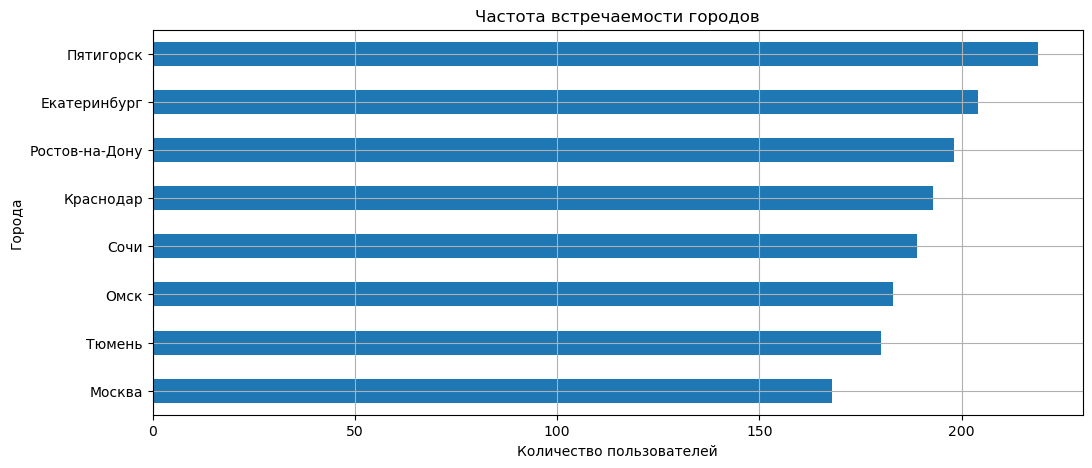

In [16]:
# вывели график встречаемости городов
city.plot(kind='barh', grid=True, figsize=(12, 5), legend=False)
plt.xlabel('Количество пользователей')
plt.ylabel('Города')
plt.title('Частота встречаемости городов')
plt.show()

In [17]:
print(
    'В Пятигорске больше пользователей, чем в Москве на - {:.1%}'
      .format(city['количество пользователей'].max() / city['количество пользователей'].min() -1)
)

В Пятигорске больше пользователей, чем в Москве на - 30.4%


Из сводной таблицы и графика можно выявить, что максимальное количество пользователей встречается в городе Пятигорск, минимальное количество в Москве. Отличие составляет 30.4%.

### Cоотношение пользователей с подпиской и без подписки

In [18]:
# создали сводную таблицу по подпискам с количеством пользователей по каждой
subscription_type = data_users.pivot_table(index='subscription_type', values='user_id', aggfunc='count', )
subscription_type.columns = ['количество пользователей']
subscription_type.sort_values('количество пользователей', inplace=True)
subscription_type # вывели сводную таблицу

,количество пользователей
subscription_type,
ultra,699
free,835


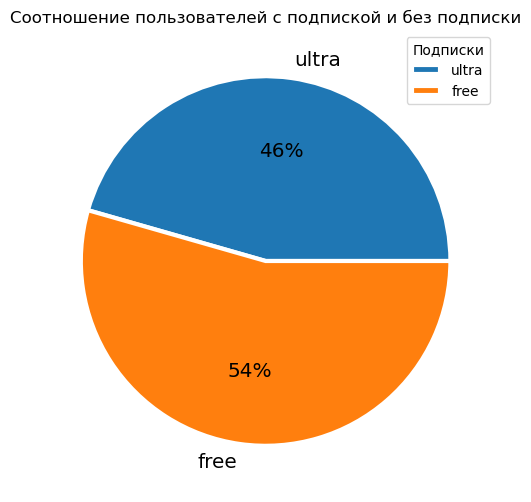

In [19]:
# вывели график соотношения пользователей с подпиской и без
subscription_type['количество пользователей'].plot(kind='pie', 
                                                   autopct='%1.0f%%', 
                                                   figsize=(12, 6),
                                                   wedgeprops={'linewidth': 3.0, 'edgecolor': 'white'},
                                                   textprops={'size': 'x-large'}
                                                  )
plt.ylabel('')
plt.title('Cоотношение пользователей с подпиской и без подписки')
plt.legend(title='Подписки', bbox_to_anchor=(1, 1))
plt.show()

In [20]:
print('Количество пользователей без подписки больше на',
    subscription_type['количество пользователей'][1] - subscription_type['количество пользователей'][0]
)

Количество пользователей без подписки больше на 136


Из сводной таблицы и графика можно выявить, что пользователей без подписки больше, чем пользователей с подпиской. Отличие составляет 8% или 136 пользователей.

### Возраст пользователей

In [21]:
# создали сводную таблицу по возрасту пользователей
age = data_users.pivot_table(index='age', values='user_id', aggfunc='count')
age.columns = ['Количество пользователей']

<Axes: >

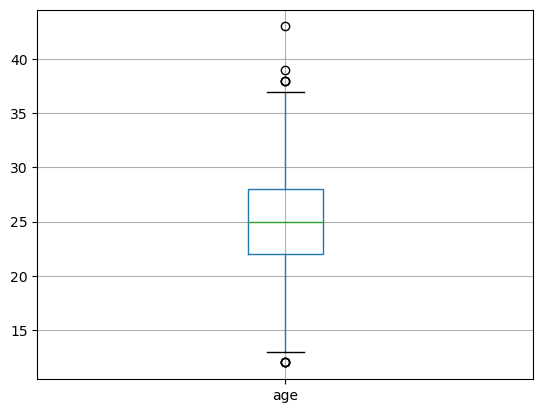

In [22]:
# построили диаграмму размаха для оценки распределения пользователей по возрасту
data_users.boxplot('age')

In [23]:
# вывели статистику столбца age  
data_users['age'].describe()

count    1534.000000
mean       24.903520
std         4.572367
min        12.000000
25%        22.000000
50%        25.000000
75%        28.000000
max        43.000000
Name: age, dtype: float64

In [24]:
# вывели выброс по возрасту 12 лет
data_users[data_users['age'] == 12]

,user_id,name,age,city,subscription_type
34,35,Руслан,12,Пятигорск,ultra
66,67,Анастасия,12,Ростов-на-Дону,ultra
664,665,Герман,12,Сочи,ultra
727,728,Вячеслав,12,Пятигорск,free


In [25]:
# вывели выброс по возрасту от 37 лет
data_users[data_users['age'] > 37]

,user_id,name,age,city,subscription_type
383,384,Виктор,38,Омск,ultra
453,454,Вероника,38,Краснодар,ultra
804,805,Петр,38,Тюмень,free
961,962,Дмитрий,39,Москва,free
1201,1202,Ангелина,43,Москва,free


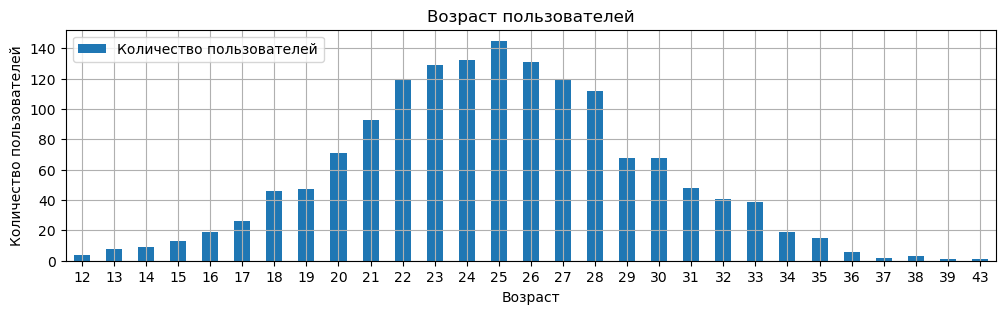

In [26]:
# нарисовали график распределения возвраста пользователей
age.plot(kind='bar', grid=True, figsize=(12, 3))
plt.xlabel('Возраст')
plt.ylabel('Количество пользователей')
plt.title('Возраст пользователей')
plt.legend(loc='upper left')
plt.xticks(rotation=0)
plt.show()

Из графиков можно наблюдать, что возраст пользователей распределен нормально. Минимальный возраст 12 лет, максимальный 43 года. Пользователи в возрасте 12 лет и от 36 лет являются выбросами, т.е. очень редкими в наблюдаемых данных. Медианный возраст 25 лет. Преобладают пользователи в возрасте от 22 до 28 лет. Масимальное количество пользователей в возрасте 25 лет.

### Расстояние, которое пользователь преодолел за одну поездку

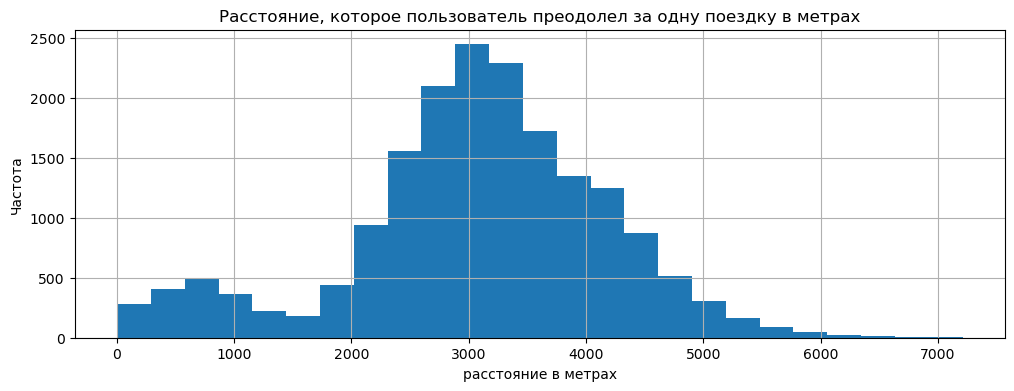

In [27]:
# нарисовали гистограмму расстояний, которые пользователи преодолевают за одну поездку
data_rides['distance'].plot(kind='hist', grid=True, figsize=(12, 4), bins=25)
plt.xlabel('расстояние в метрах')
plt.ylabel('Частота')
plt.title('Расстояние, которое пользователь преодолел за одну поездку в метрах')
plt.show()

<Axes: >

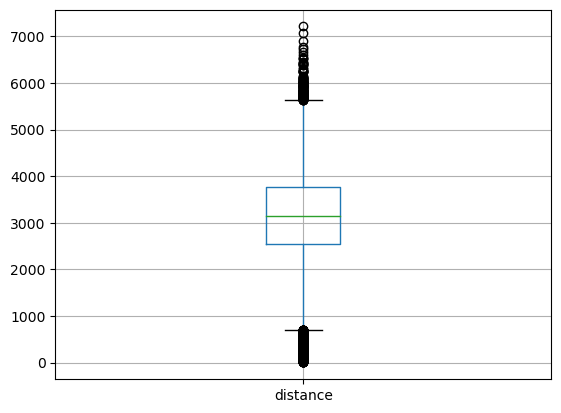

In [28]:
# построили диаграмму размаха для оценки распределения расстояний
data_rides.boxplot('distance')

In [29]:
# вывели статистику столбца distance  
data_rides['distance'].describe()

count    18068.000000
mean      3070.659976
std       1116.831209
min          0.855683
25%       2543.226360
50%       3133.609994
75%       3776.222735
max       7211.007745
Name: distance, dtype: float64

In [30]:
# вывели выброс по дистации менее 800 метров
data_rides[data_rides['distance'] < 800]

,user_id,distance,duration,date,month_number
2,1,754.159807,6.232113,2021-04-20,4
9,1,748.690645,15.041884,2021-11-22,11
47,4,724.559572,11.811399,2021-11-14,11
100,10,680.952663,5.150377,2021-02-21,2
149,15,634.891669,15.809350,2021-04-05,4
...,...,...,...,...,...
18018,1531,375.107762,5.406654,2021-06-27,6
18031,1532,303.787850,7.792490,2021-05-21,5
18037,1532,662.468186,9.528773,2021-11-18,11
18043,1533,310.488247,10.642389,2021-02-21,2


In [31]:
# вывели выброс по дистации более 5700 метров
data_rides[data_rides['distance'] > 5700]

,user_id,distance,duration,date,month_number
6549,702,5924.120648,21.156693,2021-11-19,11
6754,716,5835.527411,20.506582,2021-11-05,11
6860,724,6225.520342,0.500000,2021-12-16,12
7026,736,5787.742203,15.890581,2021-02-09,2
7043,737,6386.938020,25.967345,2021-07-31,7
...,...,...,...,...,...
17242,1477,6724.932981,0.500000,2021-01-12,1
17418,1490,5830.284286,20.660569,2021-01-22,1
17505,1496,5722.551787,0.500000,2021-02-14,2
17773,1514,6039.465068,26.421033,2021-09-28,9


In [32]:
# посчитаем основные характеристики распределения: максимум, минимум, среднее, медиану
print(f'Максимальное расстояние, которое преодолел пользователь {np.round(data_rides["distance"].max())} метра')
print(f'Минимальное расстояние, которое преодолел пользователь {np.round(data_rides["distance"].min())} метр')
print(f'Среднее расстояние, которое преодолели пользователи {np.round(data_rides["distance"].mean())} метра')
print(f'Медиана расстояний, которое преодолели пользователи {np.round(data_rides["distance"].median())} метра')

Максимальное расстояние, которое преодолел пользователь 7211.0 метра
Минимальное расстояние, которое преодолел пользователь 1.0 метр
Среднее расстояние, которое преодолели пользователи 3071.0 метра
Медиана расстояний, которое преодолели пользователи 3134.0 метра


Из графика и расчетов видно, что пользователи чаще всего проезжают за одну поездку расстояние в диапазоне от 2500 до 3700 метров. Наиболее часто встречающие расстояние за одну поездку между средней и медианой: от 3071 до 3134 метров.
Минимальное расстояние зафиксировано на уровне 1 метра, максимальное в 7211 метров. Из диаграммы размаха можно заметить, что расстояния до 800 метров и от 5700 метров являются выбросами, если не учитывать выбросы, то получим нормальное распределение расстояний, которое пользователи преодолевают за одну поездку. Можем предположить, что пользователи, которые совершают короткие поездки - едут до или от остановки общественного транспорта или метро, а пользователи, которые совершают длинные поездки - проезжают свой путь полностью до пункта назначения.

### Продолжительность поездок

<Axes: >

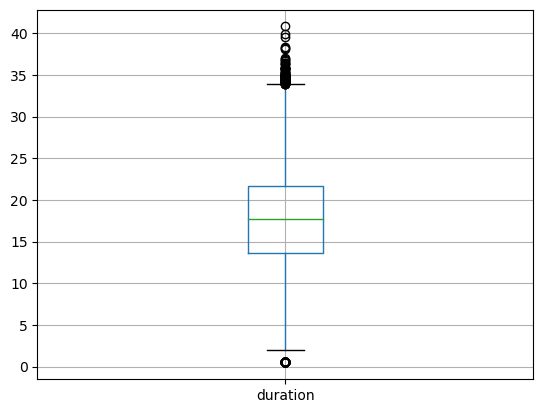

In [33]:
# построили диаграмму размаха для оценки распределения продолжительности поездок
data_rides.boxplot('duration')

In [34]:
# вывели статистику столбца duration  
data_rides['duration'].describe()

count    18068.000000
mean        17.805011
std          6.091051
min          0.500000
25%         13.597563
50%         17.678395
75%         21.724800
max         40.823963
Name: duration, dtype: float64

In [35]:
# вывели выброс минимального времени поездки
data_rides[data_rides['duration'] == 0.5]

,user_id,distance,duration,date,month_number
6531,701,4196.445201,0.5,2021-08-31,8
6570,704,4830.824371,0.5,2021-10-14,10
6680,712,4684.004397,0.5,2021-03-04,3
6695,713,5215.642710,0.5,2021-02-25,2
6768,718,5197.436649,0.5,2021-02-11,2
...,...,...,...,...,...
17004,1460,5531.335845,0.5,2021-01-19,1
17242,1477,6724.932981,0.5,2021-01-12,1
17314,1483,4445.481070,0.5,2021-03-06,3
17505,1496,5722.551787,0.5,2021-02-14,2


In [36]:
# вывели статистику столбца 'distance' по минимальному времени поездки в 0.5 минуты
# заметно, что расстояния поездки достаточны большие для такого времени
data_rides[data_rides['duration'] == 0.5]['distance'].describe()

count      95.000000
mean     5113.176549
std       658.254104
min      4030.308008
25%      4611.510820
50%      5052.769411
75%      5488.459099
max      7211.007745
Name: distance, dtype: float64

Выявили аномалию: за 0.5 минуты технически невозможно проехать на самокате минимальное расстояние от 4030 метров, таких значений 95.Удалим данную аномалию.

In [37]:
# удалили строки с продолжительностью поездки в 0.5 минуты
data_rides = data_rides[data_rides['duration'] != 0.5]

In [38]:
# вывели информацию по датафрейму data_rides после удаления строк
data_rides.info()

<class 'pandas.core.frame.DataFrame'>
Index: 17973 entries, 0 to 18067
Data columns (total 5 columns):
 #   Column        Non-Null Count  Dtype         
---  ------        --------------  -----         
 0   user_id       17973 non-null  int64         
 1   distance      17973 non-null  float64       
 2   duration      17973 non-null  float64       
 3   date          17973 non-null  datetime64[ns]
 4   month_number  17973 non-null  int32         
dtypes: datetime64[ns](1), float64(2), int32(1), int64(1)
memory usage: 772.3 KB


In [39]:
# вывели выброс времени поездки от 34 минут
data_rides[data_rides['duration'] > 34]

,user_id,distance,duration,date,month_number
42,4,4649.488243,35.896929,2021-08-14,8
143,15,4187.621459,38.125729,2021-01-13,1
499,55,4151.081878,36.906491,2021-06-30,6
524,58,4763.920660,35.819603,2021-02-17,2
854,91,4444.579979,35.222900,2021-11-05,11
...,...,...,...,...,...
17119,1468,4744.875534,34.881139,2021-06-13,6
17235,1476,4217.871874,34.006574,2021-04-13,4
17353,1485,3807.409685,34.767689,2021-12-09,12
17684,1509,3728.895778,34.339432,2021-01-22,1


In [40]:
# вывели статистику столбца 'distance' по минимальному времени поездки от 34 минут, для проверки выброса 
data_rides[data_rides['duration'] > 34]['distance'].describe()

count      75.000000
mean     4472.120090
std       502.551732
min      3672.447904
25%      4142.628260
50%      4366.325701
75%      4759.177173
max      6436.625605
Name: distance, dtype: float64

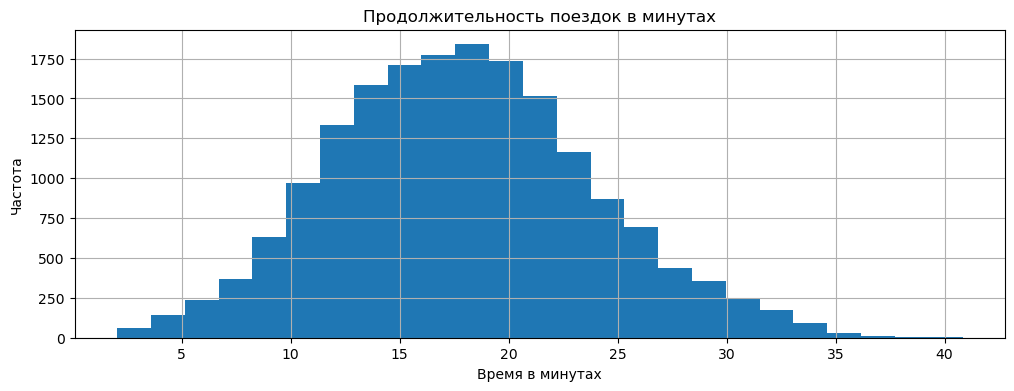

In [41]:
# нарисовали гистограмму продолжительности поездок в минутах, которые пользователи преодолевают за одну поездку
data_rides['duration'].plot(kind='hist', grid=True, figsize=(12, 4), bins=25)
plt.xlabel('Время в минутах')
plt.ylabel('Частота')
plt.title('Продолжительность поездок в минутах')
plt.show()

In [42]:
# посчитали основные характеристики распределения: максимум, минимум, среднее, медиану
print(f'Максимальная продолжительность поездки пользователем {np.round(data_rides["duration"].max())} минута')
print(f'Минимальная продолжительность поездки пользователем {np.round(data_rides["duration"].min(),2)} минут')
print(f'Средняя продолжительность поездок пользователей {np.round(data_rides["duration"].mean())} минут')
print(f'Медиана продолжительностей поездок пользователей {np.round(data_rides["duration"].median())} минут')

Максимальная продолжительность поездки пользователем 41.0 минута
Минимальная продолжительность поездки пользователем 2.04 минут
Средняя продолжительность поездок пользователей 18.0 минут
Медиана продолжительностей поездок пользователей 18.0 минут


Из графика и расчетов видно, что средняя и медианная продолжительность поездки пользователей составляет 18 минут и это время самое частно распространенное среди пользователей. Продолжительность поездки распределена нормально вокруг медианы. Диапазон самого распростараненного времени составляет от 14 до 22 минут. Из диаграммы размаха можно заметить, что продолжительность до 2 минут и от 34 минут являются выбросами. Проверив данные выбросы выявили аномалию, продолжительность поездки в 0.5 минуты на длительные расстояния более 4 километров. Данную аномалию удалили из датафрейма.

## Шаг. Объединение данных

### Объединение данных о пользователях, поездках и подписках в один датафрейм

In [43]:
# объединили 3 датафрейма в один, поместили в переменную data
data_temporary = data_users.merge(data_rides, on='user_id')
data = data_temporary.merge(data_subscriptions, on='subscription_type')

In [44]:
data.head() # вывели 5 строк объединенной таблицы для просмотра

,user_id,name,age,city,subscription_type,distance,duration,date,month_number,minute_price,start_ride_price,subscription_fee
0,1,Кира,22,Тюмень,ultra,4409.919140,25.599769,2021-01-01,1,6,0,199
1,1,Кира,22,Тюмень,ultra,2617.592153,15.816871,2021-01-18,1,6,0,199
2,1,Кира,22,Тюмень,ultra,754.159807,6.232113,2021-04-20,4,6,0,199
3,1,Кира,22,Тюмень,ultra,2694.783254,18.511000,2021-08-11,8,6,0,199
4,1,Кира,22,Тюмень,ultra,4028.687306,26.265803,2021-08-28,8,6,0,199


In [45]:
data.info() # посмотрели на общую информацию по объединенной таблице

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 17973 entries, 0 to 17972
Data columns (total 12 columns):
 #   Column             Non-Null Count  Dtype         
---  ------             --------------  -----         
 0   user_id            17973 non-null  int64         
 1   name               17973 non-null  object        
 2   age                17973 non-null  int64         
 3   city               17973 non-null  object        
 4   subscription_type  17973 non-null  object        
 5   distance           17973 non-null  float64       
 6   duration           17973 non-null  float64       
 7   date               17973 non-null  datetime64[ns]
 8   month_number       17973 non-null  int32         
 9   minute_price       17973 non-null  int64         
 10  start_ride_price   17973 non-null  int64         
 11  subscription_fee   17973 non-null  int64         
dtypes: datetime64[ns](1), float64(2), int32(1), int64(5), object(3)
memory usage: 1.6+ MB


Объединили в 1 датафрейм данные трех таблиц. Вывели общую иформацию для проверки, что таблицы корректно соединились. Количество строк равняется количеству строк таблицы с максимальным числом, количество столбцов 12. Пропущенных значений нет.

### Создание два датафрейма о пользователях с подпиской и без

Создадим ещё два датафрейма из датафрейма, созданного на этапе 4.1

#### Создание датафрейма c данными о пользователях без подписки

In [46]:
# сделали сортировку по пользователям без подписки и сохранили в переменную data_free
data_free = data[data['subscription_type'] == 'free']
data_free.head() # вывели 5 строк таблицы по пользователям без подписки

,user_id,name,age,city,subscription_type,distance,duration,date,month_number,minute_price,start_ride_price,subscription_fee
6500,700,Айдар,22,Омск,free,2515.690719,14.944286,2021-01-02,1,8,50,0
6501,700,Айдар,22,Омск,free,846.932642,16.234663,2021-02-01,2,8,50,0
6502,700,Айдар,22,Омск,free,4004.434142,20.016628,2021-02-04,2,8,50,0
6503,700,Айдар,22,Омск,free,1205.911290,9.782872,2021-02-10,2,8,50,0
6504,700,Айдар,22,Омск,free,3047.379435,17.427673,2021-02-14,2,8,50,0


In [47]:
data_free.shape # вывели размер таблицы для проверки

(11473, 12)

#### Создание датафрейма с данными о пользователях с подпиской

In [48]:
# сделали сортировку по пользователям с подпиской и сохранили в переменную data_ultra
data_ultra = data[data['subscription_type'] == 'ultra']
data_ultra.head() # вывели 5 строк таблицы по пользователям c подпиской

,user_id,name,age,city,subscription_type,distance,duration,date,month_number,minute_price,start_ride_price,subscription_fee
0,1,Кира,22,Тюмень,ultra,4409.919140,25.599769,2021-01-01,1,6,0,199
1,1,Кира,22,Тюмень,ultra,2617.592153,15.816871,2021-01-18,1,6,0,199
2,1,Кира,22,Тюмень,ultra,754.159807,6.232113,2021-04-20,4,6,0,199
3,1,Кира,22,Тюмень,ultra,2694.783254,18.511000,2021-08-11,8,6,0,199
4,1,Кира,22,Тюмень,ultra,4028.687306,26.265803,2021-08-28,8,6,0,199


In [49]:
data_ultra.shape # вывели размер таблицы для проверки

(6500, 12)

In [50]:
data_ultra.shape[0] + data_free.shape[0] # проверили что все строки подтянулись в разделенных датафреймах

17973

In [51]:
print(f'Количество поездок пользователей без подписки больше на: \
{(data_free.shape[0] / data_ultra.shape[0] - 1):.1%}'
)

Количество поездок пользователей без подписки больше на: 76.5%


Раздели объединенный датафрейм на пользователей с подпиской и без. Можно заметить, что количество поездок у пользователей без на 76.5% больше чем пользоватлей с подпиской, хотя ранее на графике соотношение пользователей с подпикой и без наблюдали небольшую разницу в 8%.

### Визуализация информации о расстоянии и времени поездок для пользователей обеих категорий

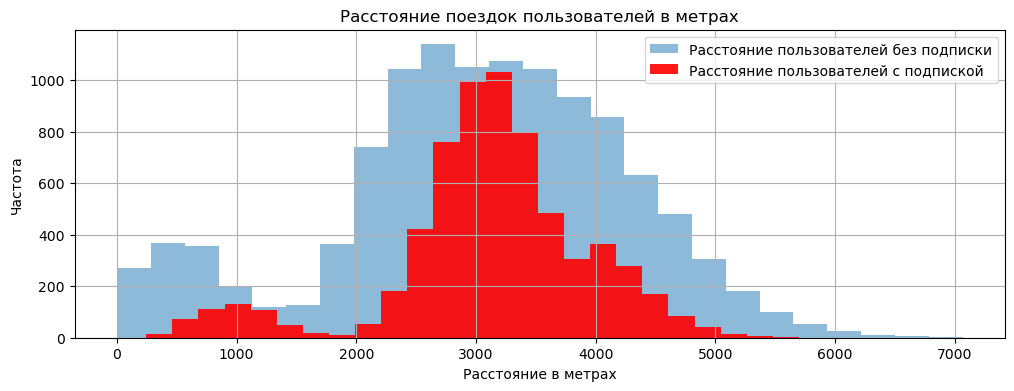

In [52]:
# нарисовали на одном графике расстояния поездок пользователей с подпиской и без
ax1 = data_free['distance'].plot(
    kind='hist', 
    bins=25,
    alpha=0.5, 
    label='Расстояние пользователей без подписки', 
    legend=True)
data_ultra['distance'].plot(
    color='red',
    figsize=(12, 4), 
    kind='hist', 
    bins=25, 
    alpha=0.9, 
    label='Расстояние пользователей с подпиской', 
    ax=ax1,
    legend=True,
    grid=True)
plt.xlabel('Расстояние в метрах')
plt.ylabel('Частота')
plt.title('Расстояние поездок пользователей в метрах')
plt.show()

In [53]:
# вывели статистику по столбку расстояние поездок пользоватлей без подписки
data_free['distance'].describe()

count    11473.000000
mean      3028.374239
std       1235.541051
min          0.855683
25%       2360.878149
50%       3102.083025
75%       3883.979311
max       7066.003772
Name: distance, dtype: float64

In [54]:
# вывели статистику по столбку расстояние поездок пользоватлей с подпиской
data_ultra['distance'].describe()

count    6500.000000
mean     3115.445388
std       836.895330
min       244.210438
25%      2785.444017
50%      3148.637229
75%      3560.574425
max      5699.769662
Name: distance, dtype: float64

Из графика видно, что разброс растояний которое проезжают пользователи без подписки относительно середины выше, чем у пользователей с подпиской. Так диапазон растояний, которые наиболее распространены у пользователей без подписки составляет от 2360 до 3883 метров, в тоже время у пользователей с подпиской диапазон уже и составляет 2785 до 3560 метров. Также пользователи с подпиской проезжают минимальное растояние от 244 метров, а пользователи без подписки могут проехать всего метр, чтобы попробовать. В п.3.4 заметили 2 пика - один характеризует короткие поездки, другой длинные поездки. Предположили, что короткие поездки совершают, чтобы добраться от или до остановки общественного транспорта. Исходя из графика такие поездки совершают чаще всего пользователей без подписки.

<div style>
<font size="4"><b></b></font>
<font size="5", color = "black">
🤝

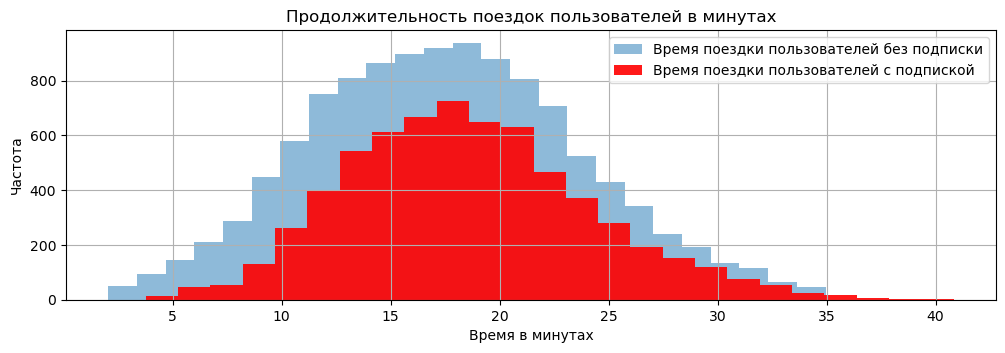

In [55]:
# нарисовали на одном графике продолжительность поездок пользователей с подпиской и без
ax2 = data_free['duration'].plot(
    kind='hist', 
    bins=25, 
    alpha=0.5, 
    label='Время поездки пользователей без подписки', 
    legend=True)
data_ultra['duration'].plot(
    color='red',
    figsize=(12, 3.5), 
    kind='hist', 
    bins=25, 
    alpha=0.9, 
    label='Время поездки пользователей с подпиской', 
    ax=ax2,
    legend=True,
    grid=True)
plt.xlabel('Время в минутах')
plt.ylabel('Частота')
plt.title('Продолжительность поездок пользователей в минутах')
plt.show()

In [56]:
# вывели статистику по столбку длительность поездок пользоватлей без подписки
data_free['duration'].describe()

count    11473.000000
mean        17.530771
std          6.162609
min          2.035632
25%         13.085688
50%         17.383807
75%         21.638038
max         34.948498
Name: duration, dtype: float64

In [57]:
# вывели статистику по столбку длительность поездок пользоватлей с подпиской
data_ultra['duration'].describe()

count    6500.000000
mean       18.541985
std         5.572048
min         3.760353
25%        14.524654
50%        18.178153
75%        21.884129
max        40.823963
Name: duration, dtype: float64

Из графика можем наблюдать, что время поездок пользователей распределено нормально у обоих категорий вокруг медианы в 18 минут и диапазоном от 13 до 22 минут. Т.к. пользователи без подписки совершают поездок больше, то и частота поездок у них выше. Минимальное время у пользователей без подписки в 2 минуты, максимальное 35 минут. У пользователей с подпиской минимальное время почти в 2 раза выше и составляет 3.7 минуты, максимальное - 40.8 минуты.

## Шаг. Подсчёт выручки

### Создание датафрейма с агрегированными данными о поездках

Создадим датафрейм с агрегированными данными о поездках на основе датафрейма с объединёнными данными из шага 4: найдем суммарное расстояние, количество поездок и суммарное время для каждого пользователя за каждый месяц

In [58]:
# округлили продолжительность поездки до следующего целого числа
data['duration'] = np.ceil(data['duration'])

In [59]:
data.head() #вывели 5 строк исходного датафрейма для просмотра

,user_id,name,age,city,subscription_type,distance,duration,date,month_number,minute_price,start_ride_price,subscription_fee
0,1,Кира,22,Тюмень,ultra,4409.919140,26.0,2021-01-01,1,6,0,199
1,1,Кира,22,Тюмень,ultra,2617.592153,16.0,2021-01-18,1,6,0,199
2,1,Кира,22,Тюмень,ultra,754.159807,7.0,2021-04-20,4,6,0,199
3,1,Кира,22,Тюмень,ultra,2694.783254,19.0,2021-08-11,8,6,0,199
4,1,Кира,22,Тюмень,ultra,4028.687306,27.0,2021-08-28,8,6,0,199


In [60]:
# создали сводную таблицу по пользователям и месяцам с суммарным растоянием, количеством поездок и суммарным временем
# поместили сводную таблицу в переменную data_profit
data_profit = data.pivot_table(
    index=['user_id', 'month_number'], values=['distance', 'duration'], aggfunc=['sum', 'count'], margins=True)
data_profit.columns = ['sum_distance', 'sum_duration', 'count_trips', 'count_trips2']
data_profit = data_profit[['sum_distance', 'count_trips', 'sum_duration']]
data_profit['sum_distance'] = np.round(data_profit['sum_distance'])
data_profit = data_profit.reset_index()
data_profit # вывели сводную таблицу с итогами, для проверки, что количество поездок не потерялось

,user_id,month_number,sum_distance,count_trips,sum_duration
0,1,1,7028.0,2,42.0
1,1,4,754.0,1,7.0
2,1,8,6723.0,2,46.0
3,1,10,5810.0,2,32.0
4,1,11,7003.0,3,56.0
...,...,...,...,...,...
11296,1534,8,7622.0,2,48.0
11297,1534,9,4928.0,1,23.0
11298,1534,11,13350.0,4,78.0
11299,1534,12,2372.0,1,16.0


In [61]:
data_profit.info() # проверили общую информацию сводной таблицы, что нет пропущенных значений и корректный тип данных

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 11301 entries, 0 to 11300
Data columns (total 5 columns):
 #   Column        Non-Null Count  Dtype  
---  ------        --------------  -----  
 0   user_id       11301 non-null  object 
 1   month_number  11301 non-null  object 
 2   sum_distance  11301 non-null  float64
 3   count_trips   11301 non-null  int64  
 4   sum_duration  11301 non-null  float64
dtypes: float64(2), int64(1), object(2)
memory usage: 441.6+ KB


### Добавление столбца в агрегированный датафрейм с помесячной выручкой по пользователям

В датафрейм с агрегированными данными добавим столбец с помесячной выручкой, которую принёс каждый пользователь. Для этого добавим столбцы из датафрейма data_users - столбец с типом подписки и с датафрейма data_subscriptions - столбцы стоимость минуты, стоимость старта, стоимость подписки.

In [62]:
# добавили в агрегированную таблицу недостающие столбцы для корректного расчета помесячной выручки по пользователям
data_profit = data_profit.merge(data_users[['user_id', 'subscription_type']], on='user_id', how='left')
data_profit = data_profit.merge(data_subscriptions, on='subscription_type', how='left')
data_profit.head() # вывели 5 строк таблицы                             

,user_id,month_number,sum_distance,count_trips,sum_duration,subscription_type,minute_price,start_ride_price,subscription_fee
0,1,1,7028.0,2,42.0,ultra,6.0,0.0,199.0
1,1,4,754.0,1,7.0,ultra,6.0,0.0,199.0
2,1,8,6723.0,2,46.0,ultra,6.0,0.0,199.0
3,1,10,5810.0,2,32.0,ultra,6.0,0.0,199.0
4,1,11,7003.0,3,56.0,ultra,6.0,0.0,199.0


In [63]:
# создали функцию для подсчета выручки по пользователям
def profit(count_trips, start_ride_price, duration, minute_price, subscription_fee):
    return count_trips * start_ride_price + duration * minute_price  + subscription_fee

In [64]:
# добавили столбец с месячной выручкой по пользователям
data_profit['profit'] = profit(data_profit['count_trips'], 
                               data_profit['start_ride_price'], 
                               data_profit['sum_duration'], 
                               data_profit['minute_price'], 
                               data_profit['subscription_fee'])
data_profit.head() # вывели 5 строк итоговой таблицы 

,user_id,month_number,sum_distance,count_trips,sum_duration,subscription_type,minute_price,start_ride_price,subscription_fee,profit
0,1,1,7028.0,2,42.0,ultra,6.0,0.0,199.0,451.0
1,1,4,754.0,1,7.0,ultra,6.0,0.0,199.0,241.0
2,1,8,6723.0,2,46.0,ultra,6.0,0.0,199.0,475.0
3,1,10,5810.0,2,32.0,ultra,6.0,0.0,199.0,391.0
4,1,11,7003.0,3,56.0,ultra,6.0,0.0,199.0,535.0


In [65]:
data_profit.info() # вывели информацию по итоговой таблице для проверки, что ничего не потерялось.
# в последних добавленных столбцах на 1 строчку меньше, т.к. не считались итоги

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 11301 entries, 0 to 11300
Data columns (total 10 columns):
 #   Column             Non-Null Count  Dtype  
---  ------             --------------  -----  
 0   user_id            11301 non-null  object 
 1   month_number       11301 non-null  object 
 2   sum_distance       11301 non-null  float64
 3   count_trips        11301 non-null  int64  
 4   sum_duration       11301 non-null  float64
 5   subscription_type  11300 non-null  object 
 6   minute_price       11300 non-null  float64
 7   start_ride_price   11300 non-null  float64
 8   subscription_fee   11300 non-null  float64
 9   profit             11300 non-null  float64
dtypes: float64(6), int64(1), object(3)
memory usage: 883.0+ KB


In [66]:
# check
data_profit['profit'].sum()

3873131.0

## Шаг. Проверка гипотез

### Гипотеза 1

Важно понять, тратят ли пользователи с подпиской больше времени на поездки? Если да, то пользователи с подпиской могут быть «выгоднее» для компании. Проверим данную гипотезу. 

Используем исходные данные о продолжительности каждой сессии — отдельно для подписчиков и тех, у кого нет подписки.

In [67]:
alpha = 0.05 # задали коэффициент статистической значимости на уровне 5%

In [68]:
# посчитали средняю продолжительность времени поездки пользователей
print(
    f'Cредняя продолжительность времени поездки пользователей без подписки: \
{np.round(np.mean(data_free["duration"]))}'
)
print(
    f'Cредняя продолжительность времени поездки пользователей c подпиской: \
{np.round(np.mean(data_ultra["duration"]))}'
)

Cредняя продолжительность времени поездки пользователей без подписки: 18.0
Cредняя продолжительность времени поездки пользователей c подпиской: 19.0


In [69]:
# посчитали суммарную продолжительность времени поездки пользователей
print(
    f'Сумарная продолжительность времени поездки пользователей без подписки: \
{np.round(data_free["duration"].sum())}'
)
print(
    f'Cуммарная продолжительность времени поездки пользователей c подпиской: \
{np.round(data_ultra["duration"].sum())}'
)
print(
    f'Продолжительность времени поездки пользователей без подписки больше на: \
{(data_free["duration"].sum() / data_ultra["duration"].sum() - 1):.1%}'
)

Сумарная продолжительность времени поездки пользователей без подписки: 201131.0
Cуммарная продолжительность времени поездки пользователей c подпиской: 120523.0
Продолжительность времени поездки пользователей без подписки больше на: 66.9%


In [70]:
# создали двухвыборочный t-тест по времени поездки для выборок по пользователям с подпиской и без
# нулевая гипотеза о том, что выборки равны
# альтернативная гипотеза - среднее, из первой выборки, больше, чем среднее из второй
results_duration = st.ttest_ind(
    data_ultra['duration'],
    data_free['duration'],
    alternative='greater'
)
print(
    'p-значение ("вероятность получить наблюдаемое значение или ещё более далёкое от него"):', \
results_duration.pvalue
) # вывели полученное p-значение
if results_duration.pvalue < alpha:
    print('Отвергаем нулевую гипотезу')
else:
    print('Не получилось отвергнуть нулевую гипотезу')

p-значение ("вероятность получить наблюдаемое значение или ещё более далёкое от него"): 4.704468074453899e-28
Отвергаем нулевую гипотезу


In [71]:
# Приведены два датасета: сумма покупок, совершённых за месяц посетителями ...

sample_1 = [3071, 3636, 3454, 3151, 2185, 3259, 1727, 2263, 2015,
2582, 4815, 633, 3186, 887, 2028, 3589, 2564, 1422, 1785,
3180, 1770, 2716, 2546, 1848, 4644, 3134, 475, 2686,
1838, 3352]
sample_2 = [1211, 1228, 2157, 3699, 600, 1898, 1688, 1420, 5048, 3007,
509, 3777, 5583, 3949, 121, 1674, 4300, 1338, 3066,
3562, 1010, 2311, 462, 863, 2021, 528, 1849, 255,
1740, 2596]
alpha = .05 # критический уровень статистической значимости
# если p-value окажется меньше него - отвергнем гипотезу
results = st.ttest_ind(
sample_1,
sample_2)
print('p-значение:', results.pvalue)
if (results.pvalue < alpha):
    print("Отвергаем нулевую гипотезу")
else:
    print("Не получилось отвергнуть нулевую гипотезу")

p-значение: 0.1912450522572209
Не получилось отвергнуть нулевую гипотезу


Использовав исходные данные для двухвыборочного t-теста по времени поездки для выборок по пользователям с подпиской и без, проверили одностороннею гипотезу о том, что среднее, из первой выборки, больше, чем среднее из второй. Нулевая гипотеза состояла в том, что среднее время поездки обоих категорий равно, альтернативная - у пользователей с подпиской время больше. Получив p-значение (вероятность получить наблюдаемое значение или ещё более далёкое от него) почти равным нулю, отвергли нулевую гипотезу при уровне статистической значимости, равном 5% в пользу альтернативной. Из расчетов видно, что в среднем на 2 минуты пользователи с подпиской проезжают больше. С учетом, что количество поездок пользователей без подписки больше на 76.5%, чем у пользователей с подпиской - длительность больше только на 66.9%.

### Гипотеза 2

Расстояние одной поездки в 3130 метров — оптимальное с точки зрения износа самоката. Можно ли сказать, что среднее расстояние, которое проезжают пользователи с подпиской за одну поездку, не превышает 3130 метров? Проверим данную гипотезу.

In [72]:
value = 3130 # задали расстояние одной поездки в 3130 метров

In [73]:
# посчитали среднюю продолжительность одной поездки пользователей с подпиской
print(f'Cреднее расстояние одной поездки пользователей c подпиской: \
{np.round(np.mean(data_ultra["distance"]))} метров')

Cреднее расстояние одной поездки пользователей c подпиской: 3115.0 метров


In [74]:
# создали одновыборочный t-тест по сравнению расстояний, которые проезжают пользователи с подпиской с оптимальным
# нулевая гипотеза о том, что расстояние равно оптимальному
# альтернативная гипотеза - расстояние, которые проезжают пользователи превышает оптимальное
results_distance = st.ttest_1samp(
    data_ultra['distance'],
    value,
    alternative='greater'
)
print(
    'p-значение ("вероятность получить наблюдаемое значение или ещё более далёкое от него"):', \
results_distance.pvalue
) # вывели полученное p-значение

if results_distance.pvalue < alpha:
    print('Отвергаем нулевую гипотезу')
else:
    print('Не получилось отвергнуть нулевую гипотезу')

p-значение ("вероятность получить наблюдаемое значение или ещё более далёкое от него"): 0.9195368847849785
Не получилось отвергнуть нулевую гипотезу


Провели одновыборочный t-тест с целью проверить, что оптимальное расстояние, которое проезжают  пользовали равно в 3130 метров. Нулевая гипотеза состояла в том, что расстояния равны, альтернативная - пользователи с подпиской проезжают больше оптимального расстояния. Выборочное среднее равно 3115 метров и отличается от 3130 — предположенного в
нулевой гипотезе значения. Но это отличие недостаточно велико, чтобы сделать вывод о том, что при уровне статистической значимости 5%  можно было отвергуть нулевую гипотезу, т.к. вероятность получить наблюдаемое значение составляет 92%, что достаточно высоко. Соответствие длительности поездки пользователей с подпиской оптимальной длительности, может быть выгодным бизнесу, т.к. самокат меньше изнашивается - компания меньше тратит средст на ремонт и восстановление.

### Гипотеза 3

Нужно проверить гипотезу о том, будет ли помесячная выручка от пользователей с подпиской по месяцам выше, чем выручка от пользователей без подписки.

In [75]:
# расчитали средние выручки пользователей с подпиской и без
print(
    'Среднемесячная выручка пользоватедей с подпиской',
    np.round(np.mean(data_profit[data_profit['subscription_type'] == 'ultra']['profit']))
)
print(
    'Среднемесячная выручка пользоватедей без подписки',
    np.round(np.mean(data_profit[data_profit['subscription_type'] == 'free']['profit']))
)
print(
    'Среднемесячная выручка пользоватедей c подпиской больше на {:.1%}'.format(
    np.mean(data_profit[data_profit['subscription_type'] == 'ultra']['profit'])
    / np.mean(data_profit[data_profit['subscription_type'] == 'free']['profit']) -1
    ) 
)

Среднемесячная выручка пользоватедей с подпиской 363.0
Среднемесячная выручка пользоватедей без подписки 329.0
Среднемесячная выручка пользоватедей c подпиской больше на 10.2%


In [76]:
# расчитали суммарные выручки пользователей с подпиской и без
print(
    'Суммарная выручка пользователей с подпиской',
   data_profit[data_profit['subscription_type'] == 'ultra']['profit'].sum()
)
print(
    'Суммарная выручка пользователей без подписки',
   data_profit[data_profit['subscription_type'] == 'free']['profit'].sum()
)

print(
    'Cуммарная выручка пользователей без подписки больше на {:.1%}'.format(
    data_profit[data_profit['subscription_type'] == 'free']['profit'].sum() 
    / data_profit[data_profit['subscription_type'] == 'ultra']['profit'].sum() - 1
    )
)

Суммарная выручка пользователей с подпиской 1644537.0
Суммарная выручка пользователей без подписки 2228594.0
Cуммарная выручка пользователей без подписки больше на 35.5%


In [77]:
# создали двухвыборочный t-тест по месячной выручке пользователей для выборок по пользователям с подпиской и без
# нулевая гипотеза о том, что выборки равны
# альтернативная гипотеза - среднее, из первой выборки, больше, чем среднее из второй
results_profit = st.ttest_ind(
    data_profit[data_profit['subscription_type'] == 'ultra']['profit'],
    data_profit[data_profit['subscription_type'] == 'free']['profit'],
    alternative='greater'
)
print(
    'p-значение ("вероятность получить наблюдаемое значение или ещё более далёкое от него"):', \
results_profit.pvalue
) # вывели полученное p-значение
if results_profit.pvalue < alpha:
    print('Отвергаем нулевую гипотезу')
else:
    print('Не получилось отвергнуть нулевую гипотезу')

p-значение ("вероятность получить наблюдаемое значение или ещё более далёкое от него"): 2.0314113674863288e-30
Отвергаем нулевую гипотезу


Использовав исходные данные для двухвыборочного t-теста по месячной выручке пользователей для выборок по пользователям с подпиской и без, проверили одностороннею гипотезу о том, что среднее, из первой выборки, больше, чем среднее из второй. Нулевая гипотеза состояла в том, что средние выручки обоих категорий равны, альтернативная - у пользователей с подпиской выручка больше. Получив р-значение (вероятность получить наблюдаемое значение или ещё более далёкое от него) близким к нулю, отвергли нулевую гипотезу при уровне статистической значимости, равном 5% в пользу альтернативной. Из расчетов видно, что пользователи с подпиской приносят в среднем на 35 рублей больше выручки. Несмотря на то, что количество поездок пользователей без подписки больше на 76.5% и продолжительность их поездок больше на 66.9%, выручки они приносят только на 35.5% больше, чем пользователи с подпиской.

### Гипотеза 4

Представьте такую ситуацию: техническая команда сервиса обновила сервера, с которыми взаимодействует мобильное приложение. Она надеется, что из-за этого количество обращений в техподдержку значимо снизилось. Некоторый файл содержит для каждого пользователя данные о количестве обращений до обновления и после него. Какой тест вам понадобился бы для проверки этой гипотезы?

**Ответ** Понадобится двухвыборочный t-тест для зависимых выборок (*метод ttest_rel*) с целью проверить одностороннюю гипотезу: о том, что до изменения
(первая выборка) среднее значение переменной в генеральной совокупности было больше, чем после изменения (вторая выборка).

## Шаг. Распределения

### Выяснение по задаче от отдела маркетинга по раздаче промокодов

Отделу маркетинга GoFast поставили задачу: нужно провести акцию с раздачей промокодов на один бесплатный месяц подписки, в рамках которой как минимум 100 существующих клиентов должны продлить эту подписку. То есть по завершении периода действия подписки пользователь может либо отказаться от неё, либо продлить, совершив соответствующий платёж. Акция уже проводилась ранее и по итогу выяснилось, что после бесплатного пробного периода подписку продлевают 10 % пользователей. 

Необходимо выяснить, какое минимальное количество промокодов нужно разослать, чтобы вероятность не выполнить план была примерно 5 %. Подберем параметры распределения, описывающего эту ситуацию, построим график распределения и сформулируем ответ на вопрос о количестве промокодов.

In [78]:
#задали параметры биномиального распределения, которые описывают данную ситуацию
k1=99 # число клиентов, которые должны продлить подписку
n1 = 1161 # подобрали количество промокодов, которые нужно разослать
p1 = 0.1 # вероятноть продлить подписку

# применили метод cdf() для подсчета вероятности
print(
    'Вероятность выполнить план при {} розданных промокодов на один бесплатный месяц подписки, в рамках которой \
как минимум {} и больше существующих клиентов должны продлить эту прописку, составляет {:.1%}'
    .format(n1, k1+1, (1- binom.cdf(k=k1, n=n1, p=p1)))
)

Вероятность выполнить план при 1161 розданных промокодов на один бесплатный месяц подписки, в рамках которой как минимум 100 и больше существующих клиентов должны продлить эту прописку, составляет 95.0%


In [79]:
# задали диапазон значений k для построения графика:
binom_probs = [] # создали пустой список
for n in range(n1 + 1):
    # рассчитываем значения вероятности для биномиального распределения
    binom_prob = 1- binom.cdf(k1, n, p1)
    # добавляем значения в список 
    binom_probs.append(binom_prob)

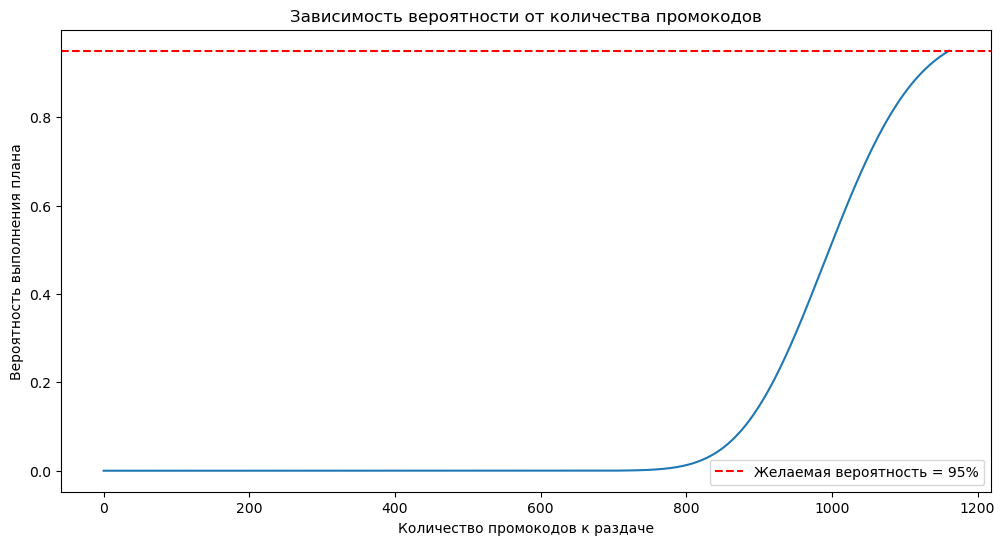

In [80]:
# рисуем график биномиального распредления
plt.figure(figsize=(12,6))
plt.plot(range(n1+1), binom_probs)
plt.xlabel('Количество промокодов к раздаче')
plt.ylabel('Вероятность выполнения плана')
plt.title('Зависимость вероятности от количества промокодов')
plt.axhline(y=0.95, color='r', linestyle='--', label='Желаемая вероятность = 95%')
plt.legend(loc='best')
plt.show()

Использовав биномиальное распределение, которое описывает указанную ситуацию. Подобрали подходящее значение параметра 
n1 для заданного параметра вероятности p=0.1 и с помощью метода cdf() определи: что необходимо раздать 1161 промокода, чтобы вероятность не выполнить план по привлечению на подписку минимум 100 пользователей составляла 5%.

### Выяснение по задаче от отдела маркетинга по push-уведомлениям

Отдел маркетинга рассылает клиентам push-уведомления в мобильном приложении. Клиенты могут открыть его или не открывать. Известно, что уведомления открывают около 40 % получивших клиентов. Отдел планирует разослать 1 млн уведомлений. 

Необходимо с помощью аппроксимации построить примерный график распределения и оценить вероятность того, что уведомление откроют не более 399,5 тыс. пользователей.

In [81]:
# задали параментры биноминального распределения
k2 = 399500 # количество пользоватлей
n2 = 1000000 # количество уведомлений
p2 = 0.4 # вероятность открыть уведомление
mu2 = n2 * p2 # математическое ожидание распредления
sigma2 = np.sqrt(mu2 * (1 - p2)) # стандартное отклонение распределения
# применили метод cdf() для подсчета вероятности
print(
    'Вероятность, что уведомление откроют не более 399,5 тыс. пользователей, составляет - {:.1%}'
      .format(binom.cdf(k=k2, n=n2, p=p2))
)

Вероятность, что уведомление откроют не более 399,5 тыс. пользователей, составляет - 15.4%


In [82]:
# зададим набор значений биномиальной величины на выбранном промежутке:
# все неотрицательные целые числа от left до right
left = int(mu2 - 4 * sigma2)
right = int(mu2 + 4 * sigma2)
x = np.linspace(left, right) # получим список чисел от left до right

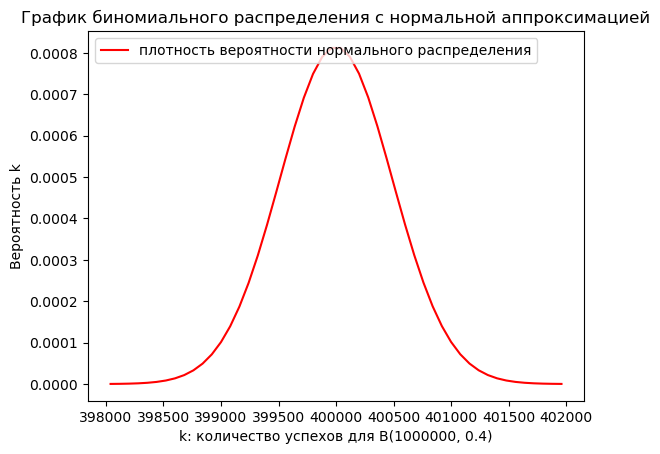

In [83]:
plt.plot(x, norm.pdf(x, mu2, sigma2), 
    'r-', label='плотность вероятности нормального распределения')
plt.legend(loc='upper left')
plt.xlabel(f'k: количество успехов для B{n2,p2}')
plt.ylabel('Вероятность k')
plt.title('График биномиального распределения с нормальной аппроксимацией')
plt.show()

 Вероятность того, что уведомление откроют не более 399,5 тыс. пользователей, при рассылке клиентам push-уведомления в мобильном приложении в размере 1 млн., составляет 15,4% 

## Общий вывод

Для проведения исследования были получены данные сервиса аренды самокатов GoFast. Данные содержали информацию о пользователях и их поездках, а также данные о финансовой информации сервиса. Было получено 3 датафрейма, проверили их на наличие пропусков и дубликатов. Провели исследовательский анализ данных, определили частоту встречаемости городов, соотношение пользователей с подпиской или без, возраст пользователей, расстояние и продолжительность поездок, которые пользователь преодолевает за одну поездку.

Необходимо было проанализировать данные и проверить некоторые гипотезы, которые могут помочь бизнесу вырасти. Для этого объединили 3 датафрейма в один. Затем разделили пользователей с подписой и без, тут выяснили, что пользователи без подписки совершают почти в 2 раза больше поездок, чем пользователи с подпиской. Создали датафрейм с агрегированными данными по количеству поездок, расстоянию и длительности - по пользователям с помесячными результатами. Добавили столбец с выручкой по каждому пользователю.

Бизнес интересовало: 

- Тратят ли пользователи с подпиской больше времени на поездки? 

Проверив нулевую гипотезу о равенстве времени на поездки обоих категорий, ее пришлось отвергнуть в пользу альтернативной - среднее время поездки пользователей с подпиской, больше, чем среднее среднее время поездки пользователей без подписки. 
 
 - Также интересовал вопрос: расстояние одной поездки в 3130 метров — оптимальное с точки зрения износа самоката. Можно ли сказать, что среднее расстояние, которое проезжают пользователи с подпиской за одну поездку, не превышает 3130 метров? 
 
В данном пункте отвергнуть нулевую гипотезу о равенстве оптимального времени и среднего времени поездки пользователей с подпиской не получилось. Вероятность получить наблюдаемое значение составляет 92%, что достаточно высоко. Бизнесу это выгодно, т.к. уменьшается износ самоката.

- Будет ли помесячная выручка от пользователей с подпиской по месяцам выше, чем выручка от пользователей без подписки. 

Проверив нулевую гипотезу о равенстве помесячной выручки обоих категорий, ее пришлось отвергнуть в пользу альтернативной - средняя помесячня выручка пользователей с подпиской, больше, чем средняя помесячня выручка пользователей без подписки.

Из расчетов видно, что пользователи с подпиской приносят в среднем на 35 рублей  или 10% больше выручки. Несмотря на то, что количество поездок пользователей без подписки больше на 76.5% и продолжительность их поездок больше на 66.9%, выручки они приносят только на 35.5% больше, чем пользователи с подпиской. В данном случае пользователи с подпиской для бизнеса выгоднее. Отделу маркетинга стоит исследовать причины почему пользователи не приобритают подпису, как рекомендация провести опрос в приложении. При вероятности 10% на продление подписки при раздаче промокодов на 1 бесплатный месяц, всем пользователям без подписки, а их всего 136, получим только одного пользователя с подпиской - данная акция может быть не выгодна бизнесу. Продакт-менеджерам сервиса следуют продумать другие методы стимулирования пользователей оформить подписку.